<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [276]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [277]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-02-23 05:23:31--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.001s  

2021-02-23 05:23:31 (15.6 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [278]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [279]:
df.shape

(346, 10)

### Convert to date time object 

In [280]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [281]:
df['loan_status'].value_counts()
# Loan collection = recouvrement

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [282]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

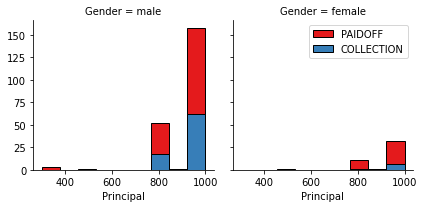

In [283]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

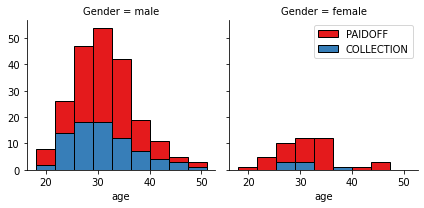

In [284]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

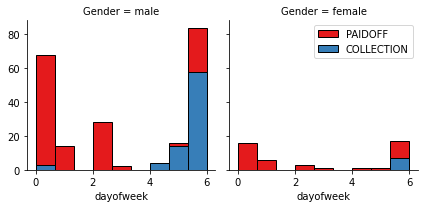

In [285]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [286]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [287]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [288]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [289]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [290]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [291]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [292]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [293]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [294]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

## Install scikit-learn

In [295]:
# !pip install scikit-learn==0.23.1

## Prepare Train and Test set for all models
random_state allows to generate allways the same train / test sets
test_size is the percentage of cases used in the test set, here 30 %

In [296]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

## Check data in X_train, y_train, X_test, y_test

In [297]:
print(X_train[0:5])
print(y_train[0:5])
print(X_test[0:5])
print(y_test[0:5])

[[ 0.51578458 -1.96168647  0.01006414 -0.42056004 -1.20577805 -0.38170062
  -0.87997669  1.14984679]
 [-1.31458942 -0.95911111 -0.65321055 -0.42056004 -1.20577805 -0.38170062
  -0.87997669  1.14984679]
 [-1.31458942 -0.95911111  1.83406953 -0.42056004 -1.20577805 -0.38170062
  -0.87997669  1.14984679]
 [-1.31458942 -0.95911111 -1.48230391 -0.42056004  0.82934003 -0.38170062
  -0.87997669  1.14984679]
 [-1.31458942 -0.95911111  1.33661351 -0.42056004 -1.20577805 -0.38170062
   1.13639374 -0.86968108]]
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF']
[[ 0.51578458 -1.96168647 -0.98484789 -0.42056004  0.82934003 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458 -0.95911111 -0.15575453 -0.42056004  0.82934003  2.61985426
  -0.87997669 -0.86968108]
 [ 0.51578458 -0.95911111 -0.81902922 -0.42056004  0.82934003 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458  0.92071769  0.50752015 -0.42056004  0.82934003 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458  0.92071769  0.839157

## Let's play with KNN : 

In [298]:
# We'll try 15 K values, to test from 1 to 15 neighbors analysed
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

Ks = range(1, 15)
knn_mean_acc = []
knn_std_acc = []
knn_mean_acc_graph = []

for n in Ks:
    knn_model = KNeighborsClassifier(n_neighbors = n)
    knn_model.fit(X_train, y_train)
    knn_yhat = knn_model.predict(X_test)
    knn_mean_acc.append([n, metrics.accuracy_score(y_test, knn_yhat)])
    knn_mean_acc_graph.append(metrics.accuracy_score(y_test, knn_yhat))
    knn_std_acc.append(np.std(knn_yhat==y_test)/np.sqrt(knn_yhat.shape[0]))

print(knn_mean_acc)

[[1, 0.6428571428571429], [2, 0.5571428571428572], [3, 0.7142857142857143], [4, 0.6285714285714286], [5, 0.7571428571428571], [6, 0.6571428571428571], [7, 0.7571428571428571], [8, 0.7142857142857143], [9, 0.7], [10, 0.6857142857142857], [11, 0.7285714285714285], [12, 0.6714285714285714], [13, 0.7142857142857143], [14, 0.7]]


In [299]:
for i in range(0, len(knn_mean_acc)):
    print("k = {} has a Score = {} ".format(i+1, knn_mean_acc_graph[i]))

k = 1 has a Score = 0.6428571428571429 
k = 2 has a Score = 0.5571428571428572 
k = 3 has a Score = 0.7142857142857143 
k = 4 has a Score = 0.6285714285714286 
k = 5 has a Score = 0.7571428571428571 
k = 6 has a Score = 0.6571428571428571 
k = 7 has a Score = 0.7571428571428571 
k = 8 has a Score = 0.7142857142857143 
k = 9 has a Score = 0.7 
k = 10 has a Score = 0.6857142857142857 
k = 11 has a Score = 0.7285714285714285 
k = 12 has a Score = 0.6714285714285714 
k = 13 has a Score = 0.7142857142857143 
k = 14 has a Score = 0.7 


## Then we print the graph for K between 1 and 15 to find the best accuracy

[0.6428571428571429, 0.5571428571428572, 0.7142857142857143, 0.6285714285714286, 0.7571428571428571, 0.6571428571428571, 0.7571428571428571, 0.7142857142857143, 0.7, 0.6857142857142857, 0.7285714285714285, 0.6714285714285714, 0.7142857142857143, 0.7]
Meilleur k :  5  Score :  0.7571428571428571


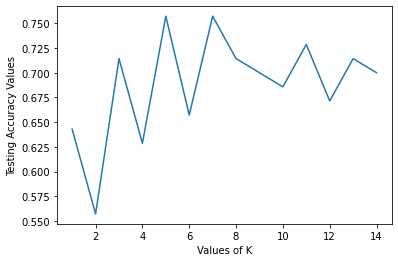

In [300]:
#Find best model
#By graph : 
plt.plot(Ks, knn_mean_acc_graph)
plt.xlabel('Values of K')
plt.ylabel('Testing Accuracy Values')
#By value :
print(knn_mean_acc_graph)
t = knn_mean_acc_graph.index(max(knn_mean_acc_graph))
print("Meilleur k : ", knn_mean_acc[t][0], " Score : ", knn_mean_acc[t][1])

In [301]:
# We found 5 as best K value
# Generate knn_yhat with this parameter : 
n = knn_mean_acc[t][0]

knn_model = KNeighborsClassifier(n_neighbors = n)
knn_model.fit(X_train,y_train)
knn_yhat = knn_model.predict(X_test)

print(knn_model)

KNeighborsClassifier()


# Decision Tree

In [302]:
# Libraries
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

In [303]:
depth_range = range(1, 10)

dt_jaccard_score = []
dt_f1_score = []

for d in depth_range:
    dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = d)
    dt_model.fit(X_train, y_train)
    dt_yhat = dt_model.predict(X_test)
    dt_jaccard_score.append(jaccard_score(y_test, dt_yhat,pos_label = "PAIDOFF"))
    dt_f1_score.append(f1_score(y_test, dt_yhat, average='weighted'))


In [304]:
result = pd.DataFrame([dt_jaccard_score, dt_f1_score], index = ['Jaccard', 'F1'], columns = range(1,10))
result.columns.name = 'Analyse'
result

Analyse,1,2,3,4,5,6,7,8,9
Jaccard,0.828571,0.828571,0.800000,0.695652,0.637681,0.666667,0.701493,0.701493,0.731343
F1,0.750893,0.750893,0.736508,0.694760,0.657958,0.676571,0.722768,0.722768,0.742857


In [305]:
#Find best model
#print(result.shape)
print("Best score : ", max(result.iloc[0]), "depth = ", result.iloc[0].idxmax(axis=0))
bs = result.iloc[0].idxmax(axis=0)

Best score :  0.8285714285714286 depth =  1


In [306]:
dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = bs)
dt_model.fit(X_train, y_train)
dt_model

DecisionTreeClassifier(criterion='entropy', max_depth=1)

# Support Vector Machine

In [307]:
from sklearn.svm import SVC
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
%matplotlib inline

In [308]:
kernel_func = ['sigmoid', 'poly', 'rbf', 'linear']
C_list = [0.01, 0.03, 0.1, 0.3, 1, 3]
accuracy_score = []
accuracy_score_data = []

for k in kernel_func:
    for c in C_list:
        svc_model = SVC(C = c, gamma = 'auto', kernel = k)
        svc_model.fit(X_train, y_train)
        svc_yhat = svc_model.predict(X_test)
        accuracy_score.append(f1_score(y_test, svc_yhat, average = 'weighted'))
        accuracy_score_data.append([k, c])
        print("Fonction : ", k, ", c = ", c, ", Score = ", f1_score(y_test, svc_yhat, average = 'weighted'))


Fonction :  sigmoid , c =  0.01 , Score =  0.7508928571428571
Fonction :  sigmoid , c =  0.03 , Score =  0.7508928571428571
Fonction :  sigmoid , c =  0.1 , Score =  0.7508928571428571
Fonction :  sigmoid , c =  0.3 , Score =  0.7437570303712036
Fonction :  sigmoid , c =  1 , Score =  0.7365079365079366
Fonction :  sigmoid , c =  3 , Score =  0.6579575783115607
Fonction :  poly , c =  0.01 , Score =  0.7508928571428571
Fonction :  poly , c =  0.03 , Score =  0.7508928571428571
Fonction :  poly , c =  0.1 , Score =  0.7508928571428571
Fonction :  poly , c =  0.3 , Score =  0.7365079365079366
Fonction :  poly , c =  1 , Score =  0.7365079365079366
Fonction :  poly , c =  3 , Score =  0.7365079365079366
Fonction :  rbf , c =  0.01 , Score =  0.7508928571428571
Fonction :  rbf , c =  0.03 , Score =  0.7508928571428571
Fonction :  rbf , c =  0.1 , Score =  0.7508928571428571
Fonction :  rbf , c =  0.3 , Score =  0.7508928571428571
Fonction :  rbf , c =  1 , Score =  0.7365079365079366
Fonct

17
Best kernel :  rbf  c :  3  score :  0.7564516129032258


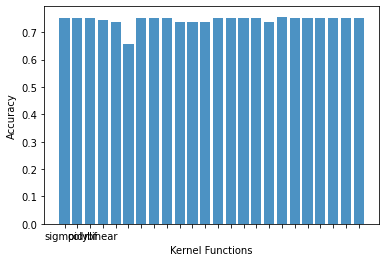

In [309]:
#Find best model
#By graph : 
y_pos = np.arange(len(kernel_func) * len(C_list))
plt.bar(y_pos, accuracy_score, align='center', alpha = 0.8)
plt.xticks(y_pos, kernel_func)
plt.xlabel('Kernel Functions')
plt.ylabel('Accuracy')
#By value : 
t = accuracy_score.index(max(accuracy_score))
print(t)
print("Best kernel : ", accuracy_score_data[t][0], " c : ", accuracy_score_data[t][1], " score : ", accuracy_score[t])

In [310]:
svc_model = SVC(C = accuracy_score_data[t][1], gamma = 'auto', kernel = accuracy_score_data[t][0])
svc_model.fit(X_train, y_train)
svc_model

SVC(C=3, gamma='auto')

# Logistic Regression

In [311]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
%matplotlib inline

In [312]:
solvers = ['lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag']
regularization_val = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
index = []
accuracy_score = []
iterations = 0

for index1, c in enumerate(regularization_val):
    for index2, solver in enumerate(solvers):
        index.append(index1 + index2 *5)
        iterations +=1
        lr_model = LogisticRegression(C = c, solver = solver)
        lr_model.fit(X_train, y_train)
        lr_yhat = lr_model.predict(X_test)
        y_prob = lr_model.predict_proba(X_test)
        print('Test {}: Accuracy at C = {} when Solver = {} is : {}'.format(iterations, c, solver, log_loss(y_test, y_prob) ))
        accuracy_score.append([c, solver, log_loss(y_test, y_prob)])
                              
    print('\n')

Test 1: Accuracy at C = 0.0001 when Solver = lbfgs is : 0.4836780802513107
Test 2: Accuracy at C = 0.0001 when Solver = saga is : 0.48368973589980474
Test 3: Accuracy at C = 0.0001 when Solver = liblinear is : 0.6904628532603395
Test 4: Accuracy at C = 0.0001 when Solver = newton-cg is : 0.4836780765047894
Test 5: Accuracy at C = 0.0001 when Solver = sag is : 0.4837312682880816


Test 6: Accuracy at C = 0.0003 when Solver = lbfgs is : 0.48250260920930627
Test 7: Accuracy at C = 0.0003 when Solver = saga is : 0.48250249283639796
Test 8: Accuracy at C = 0.0003 when Solver = liblinear is : 0.685253028001049
Test 9: Accuracy at C = 0.0003 when Solver = newton-cg is : 0.48250254194018954
Test 10: Accuracy at C = 0.0003 when Solver = sag is : 0.4824774104161967


Test 11: Accuracy at C = 0.001 when Solver = lbfgs is : 0.4787024545768455
Test 12: Accuracy at C = 0.001 when Solver = saga is : 0.47870293746390635
Test 13: Accuracy at C = 0.001 when Solver = liblinear is : 0.6685399066061889
Tes

In [313]:
#Max accuracy : 
print(accuracy_score[pd.DataFrame(accuracy_score)[2].idxmax(axis=0)])
#Solver : liblinear, C = 0.0001

[0.0001, 'liblinear', 0.6904628532603395]


In [314]:
from sklearn.linear_model import LogisticRegression 

lr_model = LogisticRegression(C = 0.0001, solver = 'liblinear')
lr_model.fit(X_train, y_train)
lr_model

LogisticRegression(C=0.0001, solver='liblinear')

# Model Evaluation using Test set

In [315]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [316]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-02-23 05:23:34--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-02-23 05:23:34 (96.6 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [317]:
test_df = pd.read_csv('loan_test.csv')
#test_df.education.values

#pd.get_dummies(test_df['education'])

In [318]:
# We apply transformations to this new data set : 
# Convert to date time object
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

#Lets look at the day of the week people get the loan
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

#Lets convert male to 0 and female to 1
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

#Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)

# Testing feature
X_loan_test = test_feature

# Normalizing Test Data
X_loan_test = preprocessing.StandardScaler().fit(X_loan_test).transform(X_loan_test)

# Target result
y_loan_test = test_df['loan_status'].values

In [319]:
print(test_feature.head())

print (X_loan_test[0:5])
print (X_loan_test.shape)

print (y_loan_test[0:5])
print (y_loan_test.shape)

   Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   50       1        0         1                     0   
1        300      7   35       0        1         0                     0   
2       1000     30   43       1        1         0                     1   
3       1000     30   26       0        1         0                     0   
4        800     15   29       0        1         1                     0   

   college  
0        0  
1        0  
2        0  
3        1  
4        0  
[[ 0.49362588  0.92844966  3.05981865  1.97714211 -1.30384048  2.39791576
  -0.79772404 -0.86135677]
 [-3.56269116 -1.70427745  0.53336288 -0.50578054  0.76696499 -0.41702883
  -0.79772404 -0.86135677]
 [ 0.49362588  0.92844966  1.88080596  1.97714211  0.76696499 -0.41702883
   1.25356634 -0.86135677]
 [ 0.49362588  0.92844966 -0.98251057 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [-0.66532184 -0.78854628 -0.47721942 -0.50578054  0.76

In [320]:
knn_yhat_new = knn_model.predict(X_loan_test)
print(knn_yhat_new.shape)
dt_yhat_new = dt_model.predict(X_loan_test)
print(dt_yhat_new.shape)
svc_yhat_new = svc_model.predict(X_loan_test)
print(svc_yhat_new.shape)
lr_yhat_new = lr_model.predict(X_loan_test)
print(lr_yhat_new.shape)

print(y_loan_test.shape)

(54,)
(54,)
(54,)
(54,)
(54,)


In [321]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

knn_jaccard_score = jaccard_score(y_loan_test, knn_yhat_new, pos_label = "PAIDOFF")
knn_f1_score = f1_score(y_loan_test, knn_yhat_new, average='weighted')

dt_jaccard_score = jaccard_score(y_loan_test, dt_yhat_new, pos_label = "PAIDOFF")
dt_f1_score = f1_score(y_loan_test, dt_yhat_new, average='weighted')

svc_jaccard_score = jaccard_score(y_loan_test, svc_yhat_new, pos_label = "PAIDOFF")
svc_f1_score = f1_score(y_loan_test, svc_yhat_new, average='weighted')

lr_jaccard_score = jaccard_score(y_loan_test, lr_yhat_new, pos_label = "PAIDOFF")
lr_f1_score = f1_score(y_loan_test, lr_yhat_new, average='weighted')

lr_prob = lr_model.predict_proba(X_loan_test)
lr_log_loss = log_loss(y_loan_test, lr_prob)



In [332]:
check_df = pd.DataFrame([knn_yhat_new,dt_yhat_new,svc_yhat_new,lr_yhat_new,y_loan_test])
print(check_df)

        0        1           2           3           4           5        6   \
0  PAIDOFF  PAIDOFF  COLLECTION  COLLECTION  COLLECTION  COLLECTION  PAIDOFF   
1  PAIDOFF  PAIDOFF     PAIDOFF     PAIDOFF     PAIDOFF     PAIDOFF  PAIDOFF   
2  PAIDOFF  PAIDOFF  COLLECTION     PAIDOFF  COLLECTION     PAIDOFF  PAIDOFF   
3  PAIDOFF  PAIDOFF     PAIDOFF  COLLECTION     PAIDOFF     PAIDOFF  PAIDOFF   
4  PAIDOFF  PAIDOFF     PAIDOFF     PAIDOFF     PAIDOFF     PAIDOFF  PAIDOFF   

        7        8        9   ...          44          45          46  \
0  PAIDOFF  PAIDOFF  PAIDOFF  ...  COLLECTION     PAIDOFF     PAIDOFF   
1  PAIDOFF  PAIDOFF  PAIDOFF  ...     PAIDOFF     PAIDOFF     PAIDOFF   
2  PAIDOFF  PAIDOFF  PAIDOFF  ...  COLLECTION     PAIDOFF     PAIDOFF   
3  PAIDOFF  PAIDOFF  PAIDOFF  ...     PAIDOFF  COLLECTION     PAIDOFF   
4  PAIDOFF  PAIDOFF  PAIDOFF  ...  COLLECTION  COLLECTION  COLLECTION   

           47          48          49          50          51          52  \
0  

In [333]:
jaccard = [knn_jaccard_score, dt_jaccard_score, svc_jaccard_score, lr_jaccard_score]
f1 = [knn_f1_score, dt_f1_score, svc_f1_score, lr_f1_score]
log_loss = ['NA', 'NA', 'NA', lr_log_loss]

col = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
row = ['Jaccard', 'F1-score', 'Logloss']

final_df = pd.DataFrame([jaccard, f1, log_loss], index = row, columns = col).transpose()
final_df.columns.name = 'Classifier'
print(final_df)

Classifier            Jaccard  F1-score   Logloss
KNN                  0.693878  0.710576        NA
Decision Tree        0.740741  0.630418        NA
SVM                  0.755102  0.755227        NA
Logistic Regression  0.755102  0.755227  0.690531


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>